In [5]:
import numpy as np
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#set random seed for reproducibility
np.random.seed(212)

# Define states
SUSCEPTIBLE, INFECTED, RECOVERED = 0, 1, 2

# Parameters 
dt = 0.04                     # time step, small to simulate continuous time
beta  = 1.0                    # infection rate (varied in paper, 0.3~4.2)
gamma = 1.0                    # infection duration (τ_I in paper, fixed time)
rho   = 1.0                    # resistance duration (τ_R = 1.0, fixed in paper)

# Time schedule for snapshots
time_space = np.arange(1, 50, 3)  # for continuous time simulation
steps = int(np.round(np.max(time_space) / dt))
print("steps:", steps)

# Grid initialization
grid_shape = (200, 200)
grid = np.zeros(grid_shape, dtype=np.uint8)
infection_timer = np.zeros(grid_shape)
recovery_timer = np.zeros(grid_shape)
susceptible_timer = np.zeros(grid_shape)

# start at random places
centers = np.random.randint(3, 180, size=(3, 2))  # 3 random centers in the grid

for x, y in centers:
    dx, dy = np.random.randint(-5, 5, 2)
    xi, yi = np.clip([x + dx, y + dy], 0, 200)
    grid[xi, yi] = INFECTED

# 8-cell Moore neighborhood kernel (used in paper)
kernel = np.array([[1, 1, 1],
                   [1, 0, 1],
                   [1, 1, 1]])

# Run the simulation
frames = []
for t in range(steps):
    # Count infected neighbors
    infected_neighbors = convolve((grid == INFECTED).astype(np.uint8), kernel, mode='constant')

    # Calculate infection probability based on PNAS paper formula
    p_inf = 1 - np.exp(-beta * infected_neighbors * dt)

    # Infect susceptible cells
    rand_vals = np.random.rand(*grid_shape)
    new_infections = (grid == SUSCEPTIBLE) & (rand_vals < p_inf) 
    grid[new_infections] = INFECTED

    recovery_timer[new_infections] = 0  # Reset recovery timer when infected
    infection_timer[new_infections] = 0
    susceptible_timer[new_infections] = 0  # Reset susceptible timer when infected

    # Update timers and state transitions
    infection_timer[grid == INFECTED] += dt
    to_recover = (grid == INFECTED) & (infection_timer >= gamma)
    grid[to_recover] = RECOVERED

    susceptible_timer[to_recover] = 0  # Reset susceptible timer when recovering
    recovery_timer[to_recover] = 0
    infection_timer[to_recover] = 0  # Optional: reset infection timer

    recovery_timer[grid == RECOVERED] += dt
    to_reset = (grid == RECOVERED) & (recovery_timer >= rho)
    grid[to_reset] = SUSCEPTIBLE

    infection_timer[to_reset] = 0  # Reset infection timer on return to susceptible
    susceptible_timer[to_reset] = 0  # Reset timer on return to susceptible
    recovery_timer[to_reset] = 0     # Optional: reset recovery timer

    # Increment susceptible timer for susceptible cells
    susceptible_timer[grid == SUSCEPTIBLE] += dt

    # Store timers as a 3D tensor for visualization/ML
    frames.append(grid.copy())

# Convert to one-hot encoded 3D array for visualization/ML
frames = np.array(frames)
frames_idx = (time_space / dt).astype(int) - 1
output = frames[frames_idx]

steps: 1225


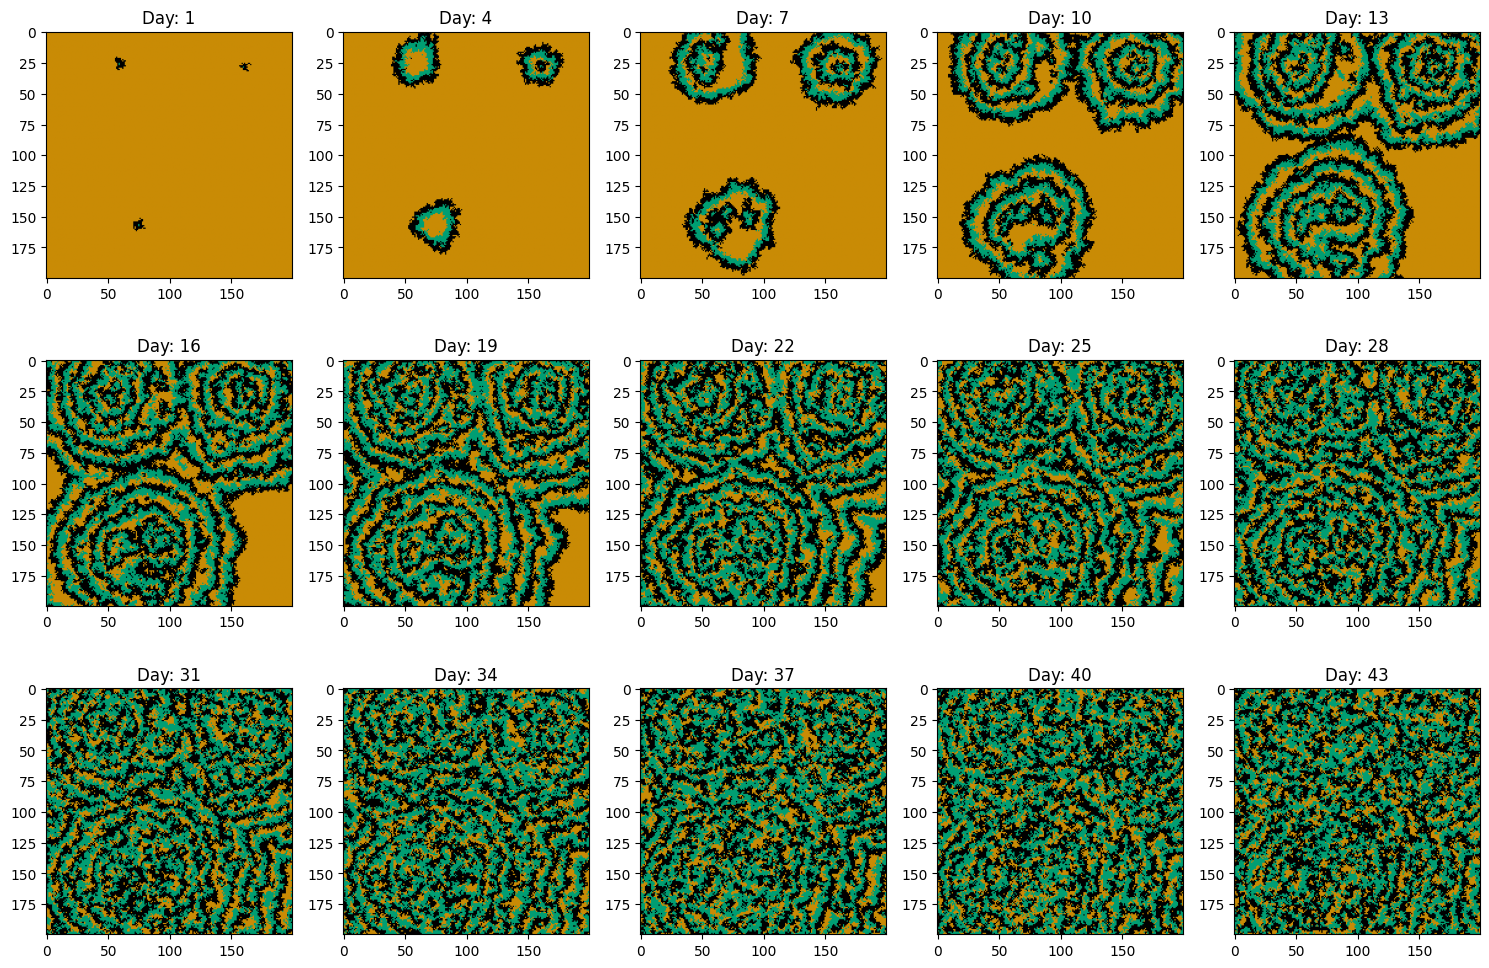

In [6]:
# my color map for visualization 
my_cmap = ListedColormap(["#C98B05", '#000000', '#009E73']) # using colorblind-friendly colors

# plot frames for visualization as subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axs.flatten()):
    if i < len(frames_idx):
        ax.imshow(output[i], cmap=my_cmap, vmin=0, vmax=2)
        ax.set_title(f'Day: {time_space[i]:}')
    else:
        ax.axis('off')  # Hide unused subplots
plt.tight_layout()

In [7]:
# # plot simulation as a video
# import matplotlib.animation as animation    
# fig, ax = plt.subplots(figsize=(6, 6))
# im = ax.imshow(frames[0], cmap=my_cmap, vmin=0, vmax=2)
# ax.set_title('Model Simulation')   
# def update(frame):
#     im.set_array(frame)
#     return [im]
# ani = animation.FuncAnimation(fig, update, frames=frames, interval=10, blit=True)

# # faster framerate for gif
# # Try using pillow writer for gif format, which is more universally available
# ani.save('sirs_simulation2.gif', writer='pillow', fps=60)